In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns

from ray import init, rllib, shutdown

In [2]:
from attack_simulator.agents import ATTACKERS
from attack_simulator.env import AttackSimulationEnv
from attack_simulator.graph import AttackGraph, SIZES

In [3]:
class NoAction(rllib.policy.Policy):
    def compute_actions(self, observations, *args, **kwargs):
        # FIXME: use a `numpy` array as a temporary workaround for
        #        https://github.com/ray-project/ray/issues/10100
        return np.zeros(len(observations)), [], {}

    def get_weights(self):
        return {}

    def set_weights(self, weights):
        pass


no_action = rllib.agents.trainer_template.build_trainer(name="NoAction", default_policy=NoAction)

In [4]:
from ray.util.client import worker

worker.INITIAL_TIMEOUT_SEC = worker.MAX_TIMEOUT_SEC = 1


def ray_init():
    if os.path.isdir("/var/run/secrets/kubernetes.io") or os.path.exists(
        os.path.expanduser("~/ray_bootstrap_config.yaml")
    ):
        # inside k8s pod or a cluster managed by Ray's autoscaler
        context = init(address="auto")
    else:
        ray_client_server = "host.docker.internal" if os.path.exists("/.dockerenv") else "127.0.0.1"
        try:
            context = init(address=f"ray://{ray_client_server}:10001")
        except ConnectionError:
            # clean up after failed connection attempt
            shutdown()
            # listen on all interfaces inside a container for port-forwarding to work
            dashboard_host = "0.0.0.0" if os.path.exists("/.dockerenv") else "127.0.0.1"
            context = init(num_cpus=4, dashboard_host=dashboard_host)
    print("\x1b[33;1m", context, "\x1b[m")
    return context

In [5]:
from tqdm.auto import tqdm

rename = dict(
    attacker="Attacker",
    graph_size="Graph size",
    episode_reward="Returns",
    episode_lengths="Episode lengths",
)

num_episodes = 5  # run 5 episodes on the same environment
attackers = list(ATTACKERS)
graphs = [AttackGraph(dict(graph_size=size)) for size in SIZES]
seeds = [0, 1, 2, 3, 6, 7, 11, 28, 42, 1337]


def generate(savename):
    ray_init()

    frames = []
    for seed in tqdm(seeds, "seeds"):
        for attacker in tqdm(attackers, f"└── {seed}"):
            for graph in tqdm(graphs, f"\u00a0\u2001\u2001\u2001└── {attacker}@{seed}"):
                config = dict(
                    log_level="CRITICAL",
                    framework="torch",
                    env=AttackSimulationEnv,
                    env_config=dict(attack_graph=graph, attacker=attacker),
                    seed=seed,
                    num_workers=0,
                    rollout_fragment_length=0,
                    evaluation_interval=1,
                    evaluation_num_workers=1,
                    evaluation_config=dict(explore=False),
                    evaluation_num_episodes=num_episodes,
                )
                agent = no_action(config=config)
                try:
                    stats = agent.evaluate()["evaluation"]["hist_stats"]
                    frame = pd.DataFrame(
                        dict(attacker=attacker, graph_size=graph.num_attacks, **stats)
                    )
                    frames.append(frame)
                except Exception as e:
                    print(seed, attacker, graph.graph_size, e)
                agent.stop()

    shutdown()
    results_df = pd.concat(frames, ignore_index=True).rename(columns=rename)
    results_df.to_csv(savename)
    return results_df

AttackGraph(en2720.yaml[tiny], 2 services, 7 attack steps)
AttackGraph(en2720.yaml[small], 5 services, 27 attack steps)
AttackGraph(en2720.yaml[medium-small], 9 services, 44 attack steps)
AttackGraph(en2720.yaml[medium], 13 services, 56 attack steps)
AttackGraph(en2720.yaml[large], 16 services, 62 attack steps)
AttackGraph(en2720.yaml[extra-large], 16 services, 65 attack steps)
AttackGraph(en2720.yaml[full], 18 services, 78 attack steps)


In [6]:
savename = "length-agent-eval.csv"

df = generate(savename) if not os.path.exists(savename) else pd.read_csv(savename, index_col=0)

2021-11-17 21:14:00,256	INFO worker.py:822 -- Connecting to existing Ray cluster at address: 10.84.0.131:6379


 {'node_ip_address': '10.84.0.131', 'raylet_ip_address': '10.84.0.131', 'redis_address': '10.84.0.131:6379', 'object_store_address': '/tmp/ray/session_2021-11-17_20-22-56_866177_42/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2021-11-17_20-22-56_866177_42/sockets/raylet', 'webui_url': '10.84.0.131:8265', 'session_dir': '/tmp/ray/session_2021-11-17_20-22-56_866177_42', 'metrics_export_port': 60562, 'node_id': '86456cfdb0e4fb66f4724ab47873bf6bff2c7ee29e33713191609e16'} 


seeds:   0%|          | 0/10 [00:00<?, ?it/s]

└── 0:   0%|          | 0/6 [00:00<?, ?it/s]

    └── well-informed@0:   0%|          | 0/7 [00:00<?, ?it/s]

    └── informed@0:   0%|          | 0/7 [00:00<?, ?it/s]

    └── round-robin-no-action@0:   0%|          | 0/7 [00:00<?, ?it/s]

    └── round-robin@0:   0%|          | 0/7 [00:00<?, ?it/s]

    └── random-no-action@0:   0%|          | 0/7 [00:00<?, ?it/s]

    └── random@0:   0%|          | 0/7 [00:00<?, ?it/s]

└── 1:   0%|          | 0/6 [00:00<?, ?it/s]

    └── well-informed@1:   0%|          | 0/7 [00:00<?, ?it/s]

2021-11-17 21:25:29,522	WARNING worker.py:1228 -- A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff7c77ed5065e5b149fa71038304000000 Worker ID: 0e36ec503970c0d2c7dbc63cba73b0aecd00a0afba9ed15018794175 Node ID: 86456cfdb0e4fb66f4724ab47873bf6bff2c7ee29e33713191609e16 Worker IP address: 10.84.0.131 Worker port: 10038 Worker PID: 3354


1 well-informed full The actor died unexpectedly before finishing this task.


    └── informed@1:   0%|          | 0/7 [00:00<?, ?it/s]

    └── round-robin-no-action@1:   0%|          | 0/7 [00:00<?, ?it/s]

    └── round-robin@1:   0%|          | 0/7 [00:00<?, ?it/s]

    └── random-no-action@1:   0%|          | 0/7 [00:00<?, ?it/s]

    └── random@1:   0%|          | 0/7 [00:00<?, ?it/s]

└── 2:   0%|          | 0/6 [00:00<?, ?it/s]

    └── well-informed@2:   0%|          | 0/7 [00:00<?, ?it/s]

    └── informed@2:   0%|          | 0/7 [00:00<?, ?it/s]

    └── round-robin-no-action@2:   0%|          | 0/7 [00:00<?, ?it/s]

2021-11-17 21:30:35,616	WARNING import_thread.py:123 -- The actor 'RolloutWorker' has been exported 100 times. It's possible that this warning is accidental, but this may indicate that the same remote function is being defined repeatedly from within many tasks and exported to all of the workers. This can be a performance issue and can be resolved by defining the remote function on the driver instead. See https://github.com/ray-project/ray/issues/6240 for more discussion.


    └── round-robin@2:   0%|          | 0/7 [00:00<?, ?it/s]

    └── random-no-action@2:   0%|          | 0/7 [00:00<?, ?it/s]

    └── random@2:   0%|          | 0/7 [00:00<?, ?it/s]

└── 3:   0%|          | 0/6 [00:00<?, ?it/s]

    └── well-informed@3:   0%|          | 0/7 [00:00<?, ?it/s]

    └── informed@3:   0%|          | 0/7 [00:00<?, ?it/s]

    └── round-robin-no-action@3:   0%|          | 0/7 [00:00<?, ?it/s]

    └── round-robin@3:   0%|          | 0/7 [00:00<?, ?it/s]

    └── random-no-action@3:   0%|          | 0/7 [00:00<?, ?it/s]

    └── random@3:   0%|          | 0/7 [00:00<?, ?it/s]

└── 6:   0%|          | 0/6 [00:00<?, ?it/s]

    └── well-informed@6:   0%|          | 0/7 [00:00<?, ?it/s]

    └── informed@6:   0%|          | 0/7 [00:00<?, ?it/s]

    └── round-robin-no-action@6:   0%|          | 0/7 [00:00<?, ?it/s]

    └── round-robin@6:   0%|          | 0/7 [00:00<?, ?it/s]

    └── random-no-action@6:   0%|          | 0/7 [00:00<?, ?it/s]

    └── random@6:   0%|          | 0/7 [00:00<?, ?it/s]

└── 7:   0%|          | 0/6 [00:00<?, ?it/s]

    └── well-informed@7:   0%|          | 0/7 [00:00<?, ?it/s]

    └── informed@7:   0%|          | 0/7 [00:00<?, ?it/s]

    └── round-robin-no-action@7:   0%|          | 0/7 [00:00<?, ?it/s]

    └── round-robin@7:   0%|          | 0/7 [00:00<?, ?it/s]

    └── random-no-action@7:   0%|          | 0/7 [00:00<?, ?it/s]

    └── random@7:   0%|          | 0/7 [00:00<?, ?it/s]

└── 11:   0%|          | 0/6 [00:00<?, ?it/s]

    └── well-informed@11:   0%|          | 0/7 [00:00<?, ?it/s]

    └── informed@11:   0%|          | 0/7 [00:00<?, ?it/s]

    └── round-robin-no-action@11:   0%|          | 0/7 [00:00<?, ?it/s]

    └── round-robin@11:   0%|          | 0/7 [00:00<?, ?it/s]

    └── random-no-action@11:   0%|          | 0/7 [00:00<?, ?it/s]

    └── random@11:   0%|          | 0/7 [00:00<?, ?it/s]

└── 28:   0%|          | 0/6 [00:00<?, ?it/s]

    └── well-informed@28:   0%|          | 0/7 [00:00<?, ?it/s]

    └── informed@28:   0%|          | 0/7 [00:00<?, ?it/s]

    └── round-robin-no-action@28:   0%|          | 0/7 [00:00<?, ?it/s]

    └── round-robin@28:   0%|          | 0/7 [00:00<?, ?it/s]

    └── random-no-action@28:   0%|          | 0/7 [00:00<?, ?it/s]

    └── random@28:   0%|          | 0/7 [00:00<?, ?it/s]

└── 42:   0%|          | 0/6 [00:00<?, ?it/s]

    └── well-informed@42:   0%|          | 0/7 [00:00<?, ?it/s]

    └── informed@42:   0%|          | 0/7 [00:00<?, ?it/s]

    └── round-robin-no-action@42:   0%|          | 0/7 [00:00<?, ?it/s]

    └── round-robin@42:   0%|          | 0/7 [00:00<?, ?it/s]

    └── random-no-action@42:   0%|          | 0/7 [00:00<?, ?it/s]

    └── random@42:   0%|          | 0/7 [00:00<?, ?it/s]

└── 1337:   0%|          | 0/6 [00:00<?, ?it/s]

    └── well-informed@1337:   0%|          | 0/7 [00:00<?, ?it/s]

    └── informed@1337:   0%|          | 0/7 [00:00<?, ?it/s]

    └── round-robin-no-action@1337:   0%|          | 0/7 [00:00<?, ?it/s]

    └── round-robin@1337:   0%|          | 0/7 [00:00<?, ?it/s]

    └── random-no-action@1337:   0%|          | 0/7 [00:00<?, ?it/s]

    └── random@1337:   0%|          | 0/7 [00:00<?, ?it/s]

In [7]:
df

,Attacker,Graph size,Returns,Episode lengths
0,well-informed,7,5.0,203
1,well-informed,7,-7559.0,16
2,well-informed,7,-18766.0,251
3,well-informed,7,-55223.0,115
4,well-informed,7,-4852.0,8
...,...,...,...,...
2090,random,78,-254282.0,637
2091,random,78,-206349.0,800
2092,random,78,-179624.0,633
2093,random,78,-176784.0,772


In [8]:
sns.set(style="darkgrid", rc={"figure.figsize": (12, 8)})

Text(0.5, 1.0, 'Defender: no-action')

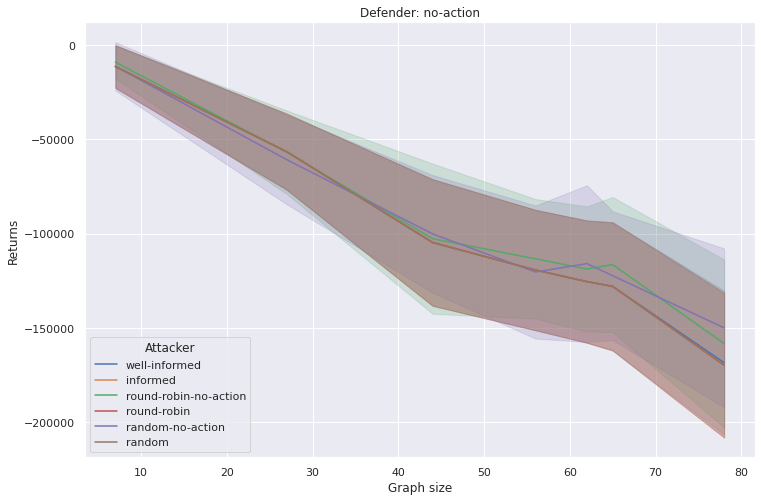

In [9]:
g = sns.lineplot(data=df, x="Graph size", y="Returns", hue="Attacker", ci="sd")
g.legend(title="Attacker", loc="lower left")
g.set_title("Defender: no-action")

Text(0.5, 1.0, 'Defender: no-action')

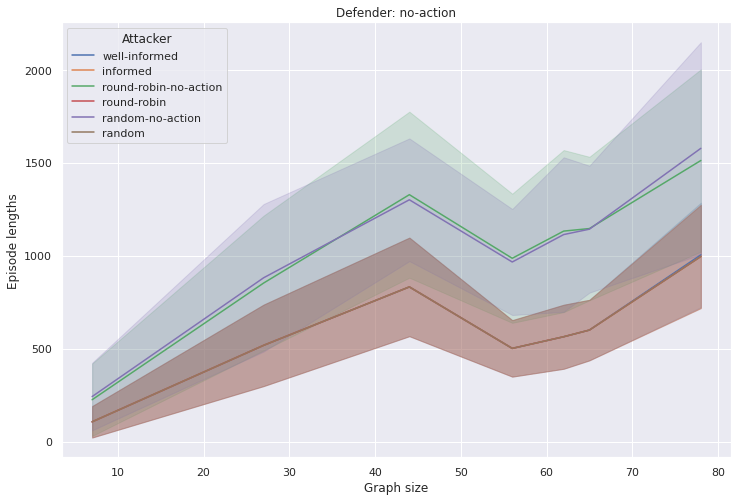

In [10]:
g = sns.lineplot(data=df, x="Graph size", y="Episode lengths", hue="Attacker", ci="sd")
g.legend(title="Attacker", loc="upper left")
g.set_title("Defender: no-action")

In [11]:
pd.set_option("display.max_columns", 32)
df.groupby("Attacker").describe()

Graph size                                               \
                           count       mean        std  min   25%   50%   75%   
Attacker                                                                        
informed                   350.0  48.428571  22.665230  7.0  27.0  56.0  65.0   
random                     350.0  48.428571  22.665230  7.0  27.0  56.0  65.0   
random-no-action           350.0  48.428571  22.665230  7.0  27.0  56.0  65.0   
round-robin                350.0  48.428571  22.665230  7.0  27.0  56.0  65.0   
round-robin-no-action      350.0  48.428571  22.665230  7.0  27.0  56.0  65.0   
well-informed              345.0  48.000000  22.545174  7.0  27.0  56.0  65.0   

                            Returns                                         \
                        max   count           mean           std       min   
Attacker                                                                     
informed               78.0   350.0 -102160.277143  56909.695503 -254282.0   
random                 78.0   350.0 -102160.277143  56909.695503 -254282.0   
random-no-action       78.0   350.0  -97239.028571  54123.508356 -249314.0   
round-robin            78.0   350.0 -102160.277143  56909.695503 -254282.0   
round-robin-no-action  78.0   350.0  -96480.102857  55632.290619 -272879.0   
well-informed          78.0   345.0 -101010.081159  56322.419723 -254282.0   

                                                           Episode lengths  \
                            25%       50%       75%    max           count   
Attacker                                                                     
informed              -142195.5 -106147.5 -63564.50    5.0           350.0   
random                -142195.5 -106147.5 -63564.50    5.0           350.0   
random-no-action      -133946.0  -97441.0 -63087.75  518.0           350.0   
round-robin           -142195.5 -106147.5 -63564.50    5.0           350.0   
round-robin-no-action -130762.0 -100245.0 -56860.25  401.0           350.0   
well-informed         -141018.0 -105207.0 -61382.00    5.0           345.0   

                                                                               \
                              mean         std   min     25%     50%      75%   
Attacker                                                                        
informed                588.391429  327.103426   8.0  388.25   568.5   784.50   
random                  588.391429  327.103426   8.0  388.25   568.5   784.50   
random-no-action       1032.042857  537.209692  21.0  694.00   994.0  1366.50   
round-robin             588.391429  327.103426   8.0  388.25   568.5   784.50   
round-robin-no-action  1026.142857  544.804554  15.0  682.25  1002.5  1311.25   
well-informed           583.597101  325.782738   8.0  383.00   561.0   782.00   

                               
                          max  
Attacker                       
informed               1831.0  
random                 1831.0  
random-no-action       3257.0  
round-robin            1831.0  
round-robin-no-action  2665.0  
well-informed          1831.0